# **Laboratorio 5 - SIS421** 

**DCGANs**

Arancibia Aguilar Daniel Andree

Ingeniería en Ciencias de la Computación

Las 5 plantas medicinales seleccionadas son:
Coca
Eucalipto
Guanabana
Lengua de Suegra
Manzanilla

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

# Definir dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


# **Exploración de datos**

In [10]:
#Definimos las rutas de las carpetas donde se encuentran nuestras imagenes
root_dir = r'E:\LAB2SIS421\500PLANTA'
classes = ['COCA', 'EUCALIPTO', 'GUANABANA', 'LENGUA DE SUEGRA', 'MANZANILLA']

#Creamos una funcion para cargar y redimensionar las imagene
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((256, 256))  # Redimensionamos las imágenes
        images.append(np.array(img))
        labels.append(label)
    return images, labels

#Cargamos las imágenes y etiquetas en un dataset
images = []
labels = []

for idx, class_name in enumerate(classes):
    folder_path = os.path.join(root_dir, class_name)
    class_images, class_labels = load_images_from_folder(folder_path, idx)
    images.extend(class_images)
    labels.extend(class_labels)
    
#Convertimos a un array numpy 
images = np.array(images)
labels = np.array(labels)


100%|██████████| 500/500 [00:03<00:00, 140.04it/s]


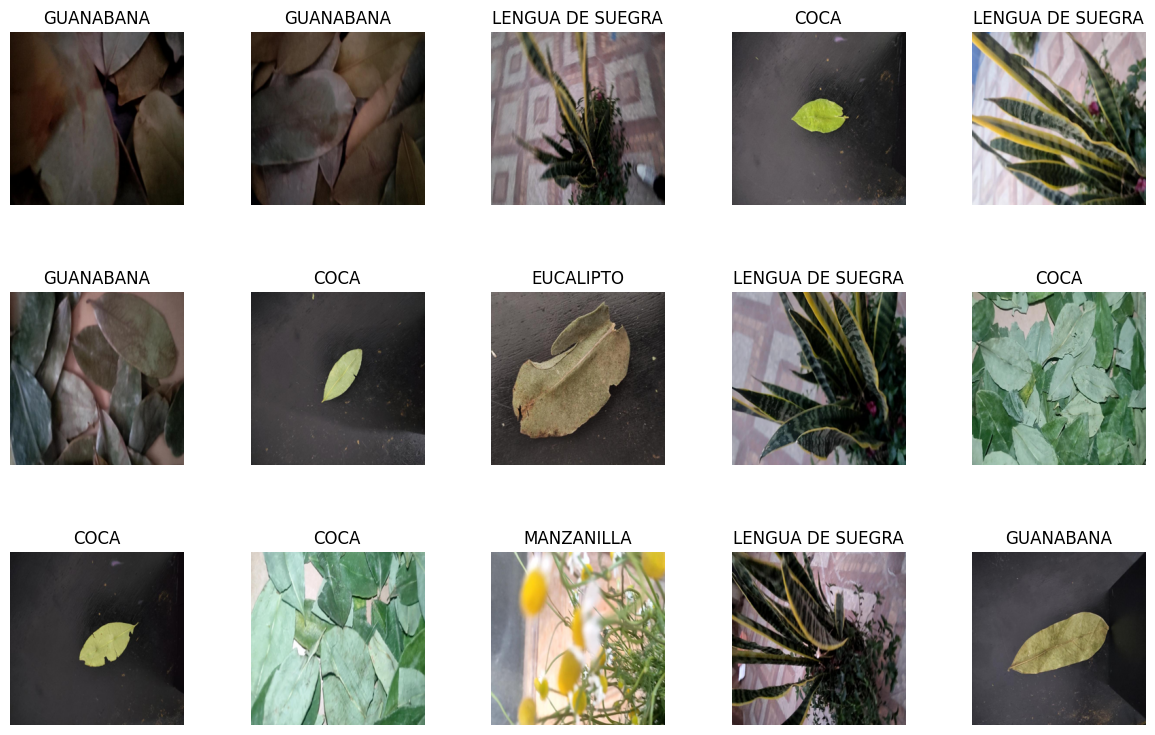

Distribución de clases en entrenamiento: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500}
Distribución de clases en testeo: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500}


In [11]:
#Visualización de imagenes
r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = np.random.randint(0, len(images))
        img, label = images[ix], labels[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


# Conteo de clases
unique_train, counts_train = np.unique(labels, return_counts=True)
print("Distribución de clases en entrenamiento:", dict(zip(unique_train, counts_train)))

unique_test, counts_test = np.unique(labels, return_counts=True)
print("Distribución de clases en testeo:", dict(zip(unique_test, counts_test)))

# **Carga del dataset**

In [12]:
# Definir transformaciones para el dataset
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar imágenes a 100x100
    transforms.ToTensor(),          # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar imágenes entre -1 y 1 (para 3 canales)
])

# Cargar el dataset
dataset_path = "E:/LAB2SIS421/500PLANTA"
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# **Definir Modelos**

In [13]:
# Definir el generador
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 25*25*128),
            nn.BatchNorm1d(25*25*128),
            nn.ReLU(True)
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),  # Cambiar a 3 canales para RGB
            nn.Tanh()
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 128, 25, 25)
        x = self.main(x)
        x = x.view(x.size(0), 3, 100, 100)  # Asegúrate de que la salida sea 3x100x100
        return x

generator = Generator().to(device)

# Definir el discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),  # Cambiar a 3 canales para RGB
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(128*25*25, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 3, 100, 100)  # Asegúrate de que la entrada sea 3x100x100
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

discriminator = Discriminator().to(device)

# **Entrenamiento**

In [25]:
import torch
import time
import os
from datetime import datetime

# Función de entrenamiento
def fit(generator, discriminator, dataloader, crit, num_epochs):
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    history = {'loss_g': [], 'loss_d': []}
    
    # Crear carpeta para guardar los checkpoints si no existe
    checkpoint_dir = 'CheckpointsDCGANs'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Tiempo de inicio del epoch
        
        for imgs, _ in dataloader:
            batch_size = imgs.size(0)
            imgs = imgs.to(device)
            
            # Entrenamiento del discriminador
            optimizer_d.zero_grad()
            
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            
            outputs = discriminator(imgs)
            d_loss_real = crit(outputs, real_labels)
            d_loss_real.backward()
            
            noise = torch.randn(batch_size, generator.input_size, device=device)
            fake_imgs = generator(noise)
            outputs = discriminator(fake_imgs.detach())
            d_loss_fake = crit(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()
            
            # Entrenamiento del generador
            optimizer_g.zero_grad()
            
            outputs = discriminator(fake_imgs)
            g_loss = crit(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()
            
        history['loss_g'].append(g_loss.item())
        history['loss_d'].append(d_loss_real.item() + d_loss_fake.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {g_loss.item()}, Loss D: {d_loss_real.item() + d_loss_fake.item()}')
        
        # Guardar el checkpoint cada 10 épocas
        if (epoch + 1) % 10 == 0:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_{timestamp}.pth')
            torch.save({
                'epoch': epoch + 1,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_g_state_dict': optimizer_g.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'loss_g': history['loss_g'],
                'loss_d': history['loss_d'],
            }, checkpoint_path)
            print(f"Checkpoint guardado en: {checkpoint_path}")
        
        epoch_end_time = time.time()  # Tiempo de finalización del epoch
        print(f"Tiempo por epoch: {epoch_end_time - epoch_start_time:.2f} segundos")
    
    # Exportar los modelos después de completar el entrenamiento
    torch.save(generator.state_dict(), 'generator_final.pth')
    torch.save(discriminator.state_dict(), 'discriminator_final.pth')
    
    return history

# Definir dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inicializar modelos
generator = Generator().to(device)
discriminator = Discriminator().to(device)


Epoch [1/200], Loss G: 1.953198790550232, Loss D: 0.3226326862350106
Tiempo por epoch: 8.87 segundos
Epoch [2/200], Loss G: 0.16501760482788086, Loss D: 0.38745133066549897
Tiempo por epoch: 8.88 segundos
Epoch [3/200], Loss G: 1.264499306678772, Loss D: 0.21755070611834526
Tiempo por epoch: 8.76 segundos
Epoch [4/200], Loss G: 6.41729736328125, Loss D: 0.0069797353353351355
Tiempo por epoch: 8.98 segundos
Epoch [5/200], Loss G: 7.498194694519043, Loss D: 0.013192168902605772
Tiempo por epoch: 9.07 segundos
Epoch [6/200], Loss G: 6.268533706665039, Loss D: 0.02358167665079236
Tiempo por epoch: 8.98 segundos
Epoch [7/200], Loss G: 3.86409330368042, Loss D: 0.04865913558751345
Tiempo por epoch: 8.87 segundos
Epoch [8/200], Loss G: 5.964656829833984, Loss D: 0.012996906516491435
Tiempo por epoch: 8.94 segundos
Epoch [9/200], Loss G: 5.477836608886719, Loss D: 0.019581408239901066
Tiempo por epoch: 9.04 segundos
Epoch [10/200], Loss G: 1.0872515439987183, Loss D: 0.4731825264170766
Checkpo

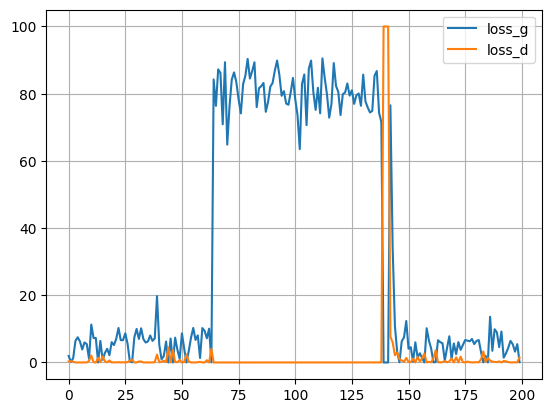

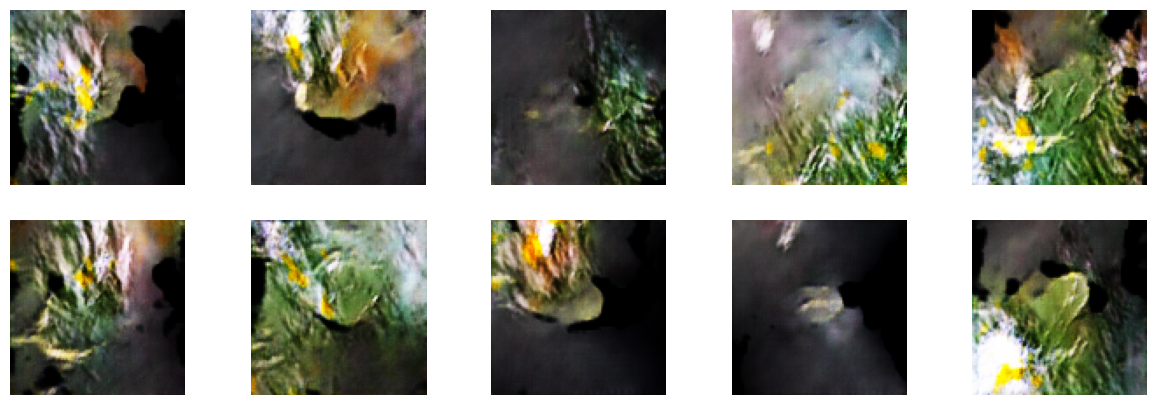

In [27]:
# Entrenamiento
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), num_epochs=200)

# Visualización de resultados
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

# Generar y mostrar imágenes
generator.eval()
with torch.no_grad():
    noise = torch.randn((10, generator.input_size)).to(device)
    generated_images = generator(noise)
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    for i, ax in enumerate(axs.flatten()):
        img = generated_images[i].cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
        ax.imshow((img * 0.5 + 0.5).clamp(0, 1))  # Desnormalizar la imagen
        ax.axis('off')
    plt.show()
